# Running filtering/smoothing using KF, EKF and UKF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from bayesfilt import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
from bayesfilt import ConstantVelocityND, CTRA, LinearObservationModel

## 1. Generate ground truth and observation using CTRA model

In [4]:
# simulating ground truth
np.random.seed(30)
dt_true = 0.1
mm_true = CTRA()
mm_true.update(dt=dt_true, sigmas=[0.0, 0.0])
tlen = 30
ncycles = 3
cur_x = [0., 0., 0., 0., 0., 0.]
ttrue = np.linspace(0,tlen,int(tlen/dt_true)+1)
ytrue = []
for t in ttrue:
    cur_x[4] = 0.5*np.sin(2.0*np.pi*ncycles*t/tlen) + np.random.randn(1)*0.01
    cur_x[5] = 0.5*np.cos(2.0*np.pi*ncycles*t/tlen) + np.random.randn(1)*0.01
    cur_x = mm_true.f(cur_x)
    ytrue.append(cur_x)
ytrue = np.asarray(ytrue).T
vx = ytrue[3,:]*np.sin(ytrue[2,:])
vy = ytrue[3,:]*np.cos(ytrue[2,:])
ax = ytrue[5,:]*np.sin(ytrue[2,:])
ay = ytrue[5,:]*np.cos(ytrue[2,:])
ytrue = np.vstack([ytrue, vx, vy, ax, ay])

In [5]:
# generating synthetic observations
observed_states = [0,1]
noise_strengths = [0.1]*2
inds = np.sort(np.random.choice(list(range(1,ytrue.shape[1]-2)), size=int(ytrue.shape[1]/3), replace=False))
inds = np.hstack([0, inds, ytrue.shape[1]-1])
tobs = ttrue[inds].copy()
yobs = np.empty((len(observed_states), len(inds)))
for i, (ix, sigma) in enumerate(zip(observed_states, noise_strengths)):
    yobs[i,:] = ytrue[ix, inds] + np.random.randn(inds.size)*sigma

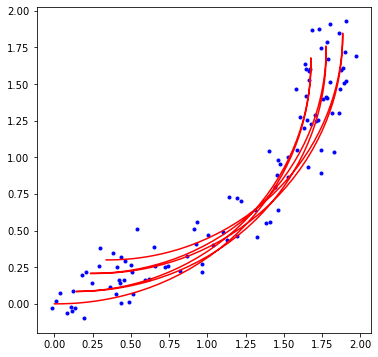

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(yobs[0], yobs[1,:], '.b')
ax.plot(ytrue[0], ytrue[1,:], '-r')

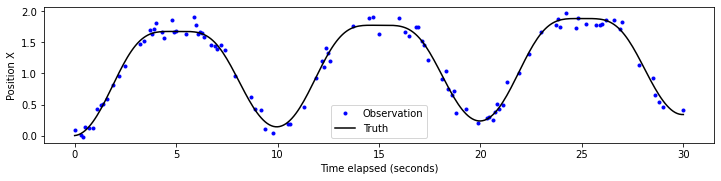

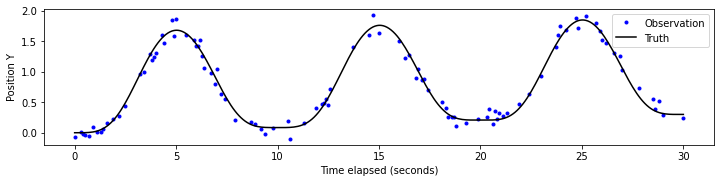

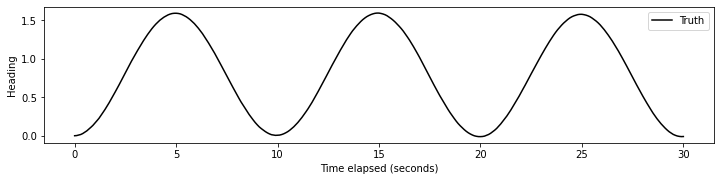

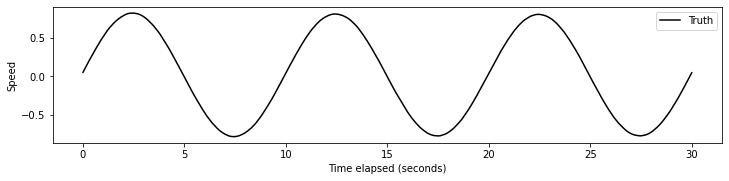

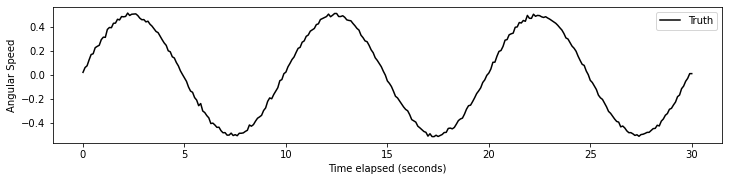

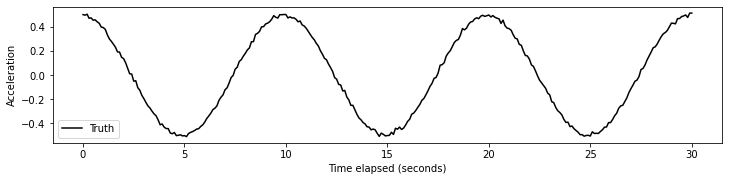

In [7]:
k = 0
for i, lbl in zip(range(mm_true.nx), mm_true.labels):
    fig, ax = plt.subplots(figsize=(12,2.5))
    if i in observed_states:
        ax.plot(tobs,yobs[k,:], '.b', label='Observation')
        k += 1
    ax.plot(ttrue,ytrue[i,:], '-k', label='Truth')
    ax.set_ylabel(lbl)
    ax.set_xlabel('Time elapsed (seconds)')
    ax.legend()

## 2. Filter/Smoothing using KF, EKF and UKF

### Motion model

In [8]:
dt = 0.02
mm = ConstantVelocityND(dof=2)
mm.update(dt = dt, sigmas = [0.25]*2)
start_x = [yobs[0,0], 0.001, yobs[1,0], 0.001]
start_P = np.diag([0.1]*4)
truth = {0:0, 1:7, 2:1, 3:6} # state-truth index pairs

### Observation model

In [9]:
observed = {0:0, 2:1} # state-observation index pairs
om = LinearObservationModel(nx=mm.nx, observed=observed)
om.update(sigmas=[0.1]*2)

### KF/KS

In [10]:
kf = KalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
kf.F = mm.F.copy()
kf.Q = mm.Q.copy()
kf.H = om.H.copy()
kf.R = om.R.copy()
kf.labels = mm.labels
kf.initiate_state(tobs[0], start_x, start_P)
kf.filter(tobs[1:], [ix for ix in yobs[:,1:].T])
kf.smoother()
print(kf.metrics)

{'nees': 436.093, 'nis': 215.359, 'loglik': 80.692, 'smoother_nees': 2443.134, 'smoother_nis': 1633.415, 'smoother_loglik': 2907.595}


### UKF/UKS

In [11]:
ukf = UnscentedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
ukf.f = mm.f
ukf.Q = mm.Q.copy()
ukf.h = om.h
ukf.R = om.R.copy()
ukf.labels = mm.labels
ukf.initiate_state(tobs[0], start_x, start_P)
ukf.filter(tobs[1:], [ix for ix in yobs[:,1:].T])
ukf.smoother()
print(ukf.metrics)

{'nees': 436.093, 'nis': 215.359, 'loglik': 80.692, 'smoother_nees': 2443.134, 'smoother_nis': 1633.415, 'smoother_loglik': 2907.595}


### EKF/EKS

In [12]:
ekf = ExtendedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
ekf.f = mm.f
ekf.compute_F = mm.compute_F
ekf.compute_Q = mm.compute_Q
ekf.h = om.h
ekf.compute_H = om.compute_H
ekf.R = om.R.copy()
ekf.labels = mm.labels
ekf.initiate_state(tobs[0], start_x, start_P)
ekf.filter(tobs[1:], [ix for ix in yobs[:,1:].T])
ekf.smoother()
print(ekf.metrics)

{'nees': 436.093, 'nis': 215.359, 'loglik': 80.692, 'smoother_nees': 2443.134, 'smoother_nis': 1633.415, 'smoother_loglik': 2907.595}


## 3. Compare and plot the results

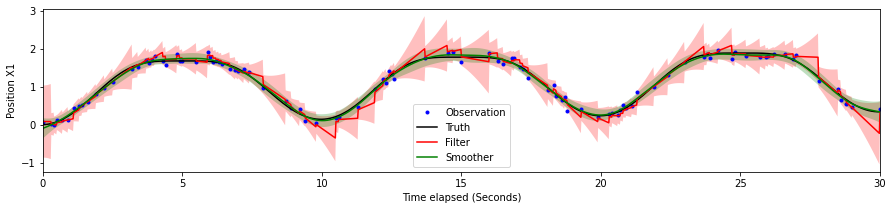

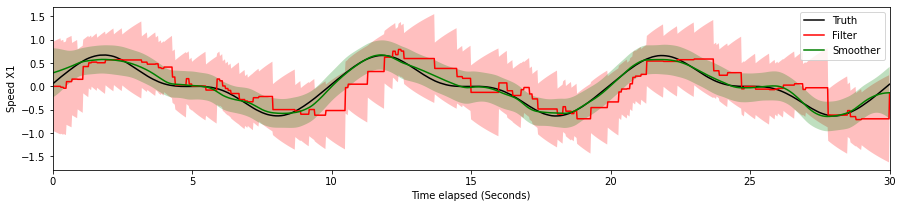

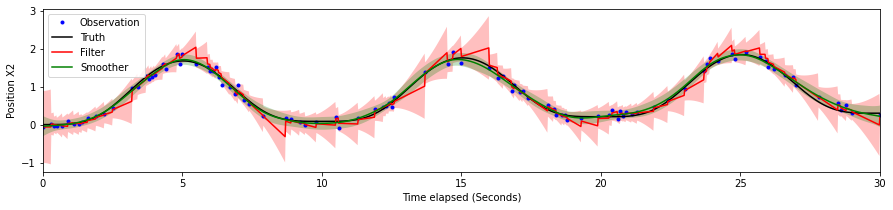

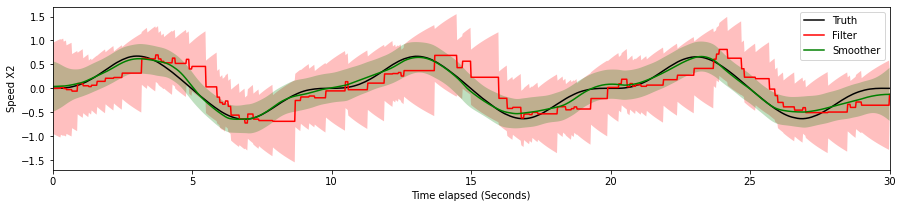

In [13]:
for i in range(mm.nx):
    fig, ax = plt.subplots(figsize=(15,3))
    for k, v in observed.items():
        if k == i:
            ax.plot(tobs, yobs[v,:], '.b', label='Observation')
    for k, v in truth.items():
        if k == i:
            ax.plot(ttrue, ytrue[v,:], '-k', label='Truth')
    kf.plot_state(ax, i, lcolor = 'r', linestyle='-', label='Filter')
    kf.plot_state(ax, i, smoother=True, lcolor = 'g',linestyle='-', label='Smoother')
    #ax.set_xlim([20,40])
    ax.legend()

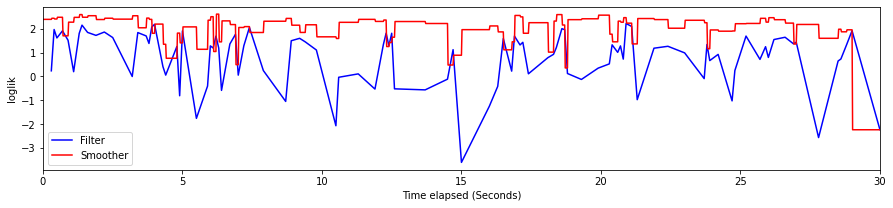

In [14]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'loglik' # 'nis', 'nees', 'loglik'
kf.plot_metric(ax, mname, color='b', label='Filter')
kf.plot_metric(ax, mname, smoother=True, color='r', label='Smoother')
ax.legend()

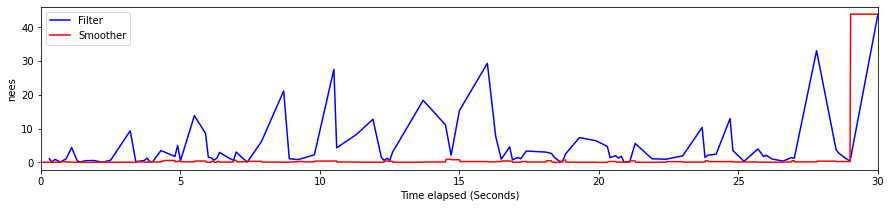

In [15]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'nees' # 'nis', 'nees', 'loglik'
kf.plot_metric(ax, mname, color='b', label='Filter')
kf.plot_metric(ax, mname, smoother=True, color='r', label='Smoother')
ax.legend()

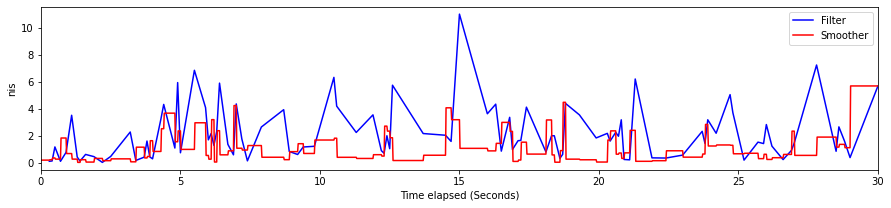

In [16]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'nis' # 'nis', 'nees', 'loglik'
kf.plot_metric(ax, mname, color='b', label='Filter')
kf.plot_metric(ax, mname, smoother=True, color='r', label='Smoother')
ax.legend()